In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from deap import base, creator, tools, algorithms
import random
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import accuracy_score

In [2]:
# Output path
output_path = '../export/sklearn/'

In [3]:
%run "../helpers/data-processing.ipynb"

Missing values in the dataset


,Column,Missing Count,Missing Percentage,Action
0,date,0,0.000000,No Missing Values
1,open,0,0.000000,No Missing Values
2,high,0,0.000000,No Missing Values
3,low,0,0.000000,No Missing Values
4,close,0,0.000000,No Missing Values
5,Volume USDT,0,0.000000,No Missing Values
6,tradecount,0,0.000000,No Missing Values
7,ema_5,0,0.000000,No Missing Values
8,ema_15,0,0.000000,No Missing Values
9,ema_30,0,0.000000,No Missing Values


Analyzing feature correlations...

The following features were dropped due to high correlation (threshold: 90%):
- HMA
- low
- KAMA
- MACD_Hist
- ema_30
- WMA
- ema_15
- close
- high
- ema_5
- ema_200
- Z-Score
- ema_60
- ema_100
- open

Performing feature selection using RandomForestClassifier...

Cross-validation accuracy scores: [1. 1. 1.]

Mean accuracy: 1.0000

The following features were selected based on feature importance:
- date
- price
- Volume USDT
- tradecount
- MACD
- MACD_Signal
- ATR
- CMO
- QStick
- price_change_ratio
- high_low_spread

Feature selection process completed.

Shape of X: (1997210, 11)


,date,price,Volume USDT,tradecount,MACD,MACD_Signal,ATR,CMO,QStick,price_change_ratio,high_low_spread
0,1.577837e+09,7180.720,509146.0,140.0,0.728704,-0.152219,4.684925,4.193879,0.120,0.000000,3.69
1,1.577837e+09,7178.470,713540.0,148.0,0.736887,-0.182091,4.698380,0.859360,0.528,-0.000313,3.76
2,1.577837e+09,7179.440,497793.0,104.0,0.846578,-0.117923,4.609025,11.466626,0.493,0.000135,5.60
3,1.577837e+09,7177.175,698627.0,193.0,0.650488,-0.343494,4.398181,-7.962104,-0.425,-0.000315,6.16
4,1.577837e+09,7175.160,241980.0,124.0,0.987398,-0.092457,4.262656,-6.795307,-0.131,-0.000281,3.86
...,...,...,...,...,...,...,...,...,...,...,...
1997205,1.698019e+09,29966.285,482950.0,635.0,-4056.925846,-1909.922487,926.278065,-97.689989,13.189,-0.000401,5.00
1997206,1.698019e+09,29970.500,169682.0,450.0,-3657.565528,-1988.042791,996.882531,-97.688910,24.399,0.000141,5.83
1997207,1.698019e+09,29975.100,111271.0,303.0,-3095.229187,-1922.717147,1072.856572,-97.688328,32.045,0.000153,3.40
1997208,1.698019e+09,29980.890,169741.0,631.0,-2332.807178,-1640.974425,1154.492462,-97.687019,22.669,0.000193,8.21



Shape of y: (1997210,)


0    1
1    0
2    1
3    0
4    0
Name: price_direction, dtype: int64

In [4]:
def trading_loss(prices, y_true, y_pred):
    # Base binary crossentropy
    bce_loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # Directional profit incentive (increase scaling factor)
    direction_correct = np.sign((y_pred - 0.5) * (y_true - 0.5))
    profit_multiplier = np.abs(y_pred - 0.5) * 2  # 0-1 range
    profit_term = direction_correct * profit_multiplier * (prices / prices.mean())  # Normalize prices
    profit_reward = -0.5 * np.mean(profit_term)  # Increased profit incentive

    # Reduce confidence penalty significantly
    confidence_penalty = 0.001 * np.mean(np.square(y_pred - 0.5))

    # Asymmetric loss for long vs. short trades
    long_bias = 1.2
    trade_bias = np.where(y_pred > 0.5, long_bias, 1.0)
    bias_loss = np.mean(trade_bias * bce_loss)

    return np.mean(bias_loss + profit_reward + confidence_penalty)

In [5]:
# Exclude date feature
X = X[:, 1:]

In [6]:
# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Reserve the last 15% as the test set
test_size = int(0.15 * len(X_scaled))
X_test, y_test = X_scaled[-test_size:], y[-test_size:]
X_train_val, y_train_val = X_scaled[:-test_size], y[:-test_size]

In [8]:
# Define time_steps globally
time_steps = 30  # Number of past time steps to use for prediction

In [9]:
def evaluate(individual, time_steps):
    # Unpack hyperparameters
    learning_rate, num_leaves, max_depth, min_child_samples, subsample, colsample_bytree = individual

    # Validate ranges
    if (learning_rate <= 0 or
            num_leaves <= 1 or
            max_depth < 1 or
            min_child_samples < 1 or
            subsample <= 0 or subsample > 1.0 or  # Changed to prevent subsample >1
            colsample_bytree <= 0 or colsample_bytree > 1.0):
        return (float('inf'),)

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=3)  # Reduced splits for speed
    fold_losses = []

    for train_idx, val_idx in tscv.split(X_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        prices_val_fold = prices[time_steps + len(X_train):time_steps + len(X_train) + len(X_val)]

        # Build model
        model = LGBMClassifier(
            learning_rate=learning_rate,
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            n_estimators=100,
            random_state=42
        )

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

        # Calculate loss for this fold
        fold_loss = trading_loss(prices_val_fold, y_val, y_pred_proba)
        fold_losses.append(fold_loss)

    # Return average loss across folds
    return (np.mean(fold_losses),)

In [10]:
def custom_mutate(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            # Learning rate
            if i == 0:
                individual[i] = max(0.01, individual[i] + random.gauss(0, 0.05))
            # subsample (index 4) and colsample_bytree (index 5)
            elif i in [4,5]:  # Handle subsample/colsample
                new_val = individual[i] + random.gauss(0, 0.1)
                individual[i] = np.clip(new_val, 0.1, 1.0)  # Force 0.1-1.0 range
            # Other parameters
            else:
                individual[i] = max(1, individual[i] + random.gauss(0, 0.05))
    return individual,

In [11]:
# Delete existing classes if they exist
if "FitnessMin" in creator.__dict__:
    del creator.FitnessMin
if "Individual" in creator.__dict__:
    del creator.Individual

In [12]:
# Define the DEAP setup
# Create the classes only if they don't exist
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Define the hyperparameter ranges
toolbox.register("attr_learning_rate", random.uniform, 0.01, 0.3)
toolbox.register("attr_num_leaves", random.randint, 20, 200)
toolbox.register("attr_max_depth", random.randint, 3, 15)
toolbox.register("attr_min_child_samples", random.randint, 10, 100)
toolbox.register("attr_subsample", random.uniform, 0.5, 1.0)
toolbox.register("attr_colsample_bytree", random.uniform, 0.5, 1.0)

# Define the individual and population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_learning_rate, toolbox.attr_num_leaves, toolbox.attr_max_depth,
                  toolbox.attr_min_child_samples, toolbox.attr_subsample, toolbox.attr_colsample_bytree), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the evaluation, crossover, mutation, and selection functions
toolbox.register("evaluate", evaluate, time_steps=time_steps)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
# toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("mutate", custom_mutate, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize the population
population = toolbox.population(n=10)

In [13]:
# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, verbose=True)

[LightGBM] [Info] Number of positive: 212614, number of negative: 211794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 424408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500966 -> initscore=0.003864
[LightGBM] [Info] Start training from score 0.003864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

([[0.2992959019738223,
   195.0,
   14.998112584532482,
   52.061936775729144,
   0.5833254713291605,
   0.7209191136722426],
  [0.2992959019738223,
   195.0,
   15.0,
   51.99999999999999,
   0.5833254713291605,
   0.6900675312887086],
  [0.2992959019738223,
   195.0,
   14.999999999999998,
   52.0,
   0.5833254713291605,
   0.6727486648152845],
  [0.2992959019738223,
   195.0,
   15.0,
   52.0,
   0.5833254713291605,
   0.7430348928628024],
  [0.2992959019738223,
   195.0,
   15.041826202777198,
   51.99999999999999,
   0.5833254713291605,
   0.6900675312887086],
  [0.2992959019738223,
   195.0,
   15.0,
   51.99999999999999,
   0.5833254713291605,
   0.6900675312887086],
  [0.2992959019738223,
   195.0,
   14.999999999999998,
   51.99999999999999,
   0.5833254713291605,
   0.7254305188015198],
  [0.2992959019738223,
   195.0,
   15.0,
   51.99999999999999,
   0.5833254713291605,
   0.7212046212601013],
  [0.2992959019738223,
   195.0,
   15.0,
   51.99999999999999,
   0.583325471329

In [14]:
# Get the best individual
best_individual = tools.selBest(population, k=1)[0]
print("Best Individual:", best_individual)

Best Individual: [0.2992959019738223, 195.0, 14.998112584532482, 52.061936775729144, 0.5833254713291605, 0.7209191136722426]


In [15]:
# Train the best model on the full training set
best_model = LGBMClassifier(
    learning_rate=best_individual[0],
    num_leaves=int(best_individual[1]),
    max_depth=int(best_individual[2]),
    min_child_samples=int(best_individual[3]),
    subsample=best_individual[4],
    colsample_bytree=best_individual[5],
    n_estimators=100,
    random_state=42
)

best_model.fit(X_train_val, y_train_val)

[LightGBM] [Info] Number of positive: 848932, number of negative: 848697
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1697629, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500069 -> initscore=0.000277
[LightGBM] [Info] Start training from score 0.000277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(colsample_bytree=0.7209191136722426,
               learning_rate=0.2992959019738223, max_depth=14,
               min_child_samples=52, num_leaves=195, random_state=42,
               subsample=0.5833254713291605)

In [16]:
# Split the remaining data into training and validation sets
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X_train_val):
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
    break  # Only use the first split for simplicity

In [17]:
# Slice prices to match each split
prices_train = prices[time_steps:time_steps + len(X_train)]
prices_val = prices[time_steps + len(X_train):time_steps + len(X_train) + len(X_val)]
prices_test = prices[-len(X_test):]  # Remaining prices for test set

In [18]:
# Evaluate on the test set
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
test_loss = trading_loss(prices_test, y_test, y_test_pred_proba)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: -0.4997


In [19]:
X_test_evaluate = X_test  # Assign X_test for evaluation
y_test_evaluate = y_test  # Assign y_test for evaluation

In [20]:
# Predict probabilities for the entire test set
predicted_probas = best_model.predict_proba(X_test)[:, 1]

In [21]:
# Smooth predicted probabilities
smoothed_probas = uniform_filter1d(predicted_probas, size=5)

In [22]:
# Adjust thresholds based on validation data
buy_threshold = np.percentile(predicted_probas, 85)  # Try top 15%
sell_threshold = np.percentile(predicted_probas, 15)  # Try bottom 15%

print(f"Dynamic Buy Threshold: {buy_threshold}")
print(f"Dynamic Sell Threshold: {sell_threshold}")

Dynamic Buy Threshold: 0.9999999991202817
Dynamic Sell Threshold: 9.550063882708327e-10


In [23]:
# Maximum fraction of the portfolio to trade
max_trade_fraction = 0.1  # up to 10% in the most confident case

In [24]:
# Minimum confidence required to trade
min_confidence = 0.3

In [25]:
# Starting portfolio values
usd_balance = 10000.0  # Starting USD balance
btc_balance = 0.0      # Starting BTC balance
buy_fee = 0.0025  # 0.25% buy fee
sell_fee = 0.004  # 0.40% sell fee

# Add risk management parameters
stop_loss_pct = 0.97  # 3% stop loss
take_profit_pct = 1.05  # 5% take profit
max_position_size = 0.25  # 25% of portfolio

# Add variables to track short positions
btc_shorted = 0.0  # Amount of BTC borrowed for short selling
short_entry_price = 0.0  # Price at which short position was opened

# Track balances and actions
usd_balances = []
btc_balances = []
actions = []
trade_percentages = []

# --- Initialize Trade Counters ---
buy_count = 0
sell_count = 0
short_count = 0
stop_loss_count = 0
take_profit_count = 0

# --- Initialize Trading Data for Plotting ---
trading_data = pd.DataFrame({
    'prices': prices_test,
    'Action': ['None'] * len(prices_test),
    'USD Balance': [0.0] * len(prices_test),
    'BTC Balance': [0.0] * len(prices_test),
    'Total Portfolio Value': [0.0] * len(prices_test)
})

# --- Initialize Balance Histories for Plotting ---
total_capital_history = []
usd_balance_history = []
btc_balance_history = []

In [26]:
# Loop over prices_test and use precomputed probabilities
for t in range(len(prices_test)):
    # Default action is 'None'
    action = 'None'
    trade_percentage = 0.0

    # Use precomputed probability
    predicted_proba = smoothed_probas[t]

    # Compute confidence: ranges from 0 (proba = 0.5) to 0.5 (proba = 0 or 1)
    confidence = abs(predicted_proba - 0.5)  # 0.0 → not sure, 0.5 → extremely sure

    # Current price
    current_price = prices_test[t]

    # Check exit conditions first
    if btc_balance > 0:
        # Check stop loss or take profit
        current_value = btc_balance * current_price
        if current_value <= entry_value * stop_loss_pct:
            # Execute stop loss
            usd_balance += current_value * (1 - sell_fee)
            btc_balance = 0
            action = 'StopLoss (Long)'
            stop_loss_count += 1
        elif current_value >= entry_value * take_profit_pct:
            # Execute take profit
            usd_balance += current_value * (1 - sell_fee)
            btc_balance = 0
            action = 'TakeProfit (Long)'
            take_profit_count += 1

    # Check exit conditions for short positions
    if btc_shorted > 0:
        current_short_value = btc_shorted * current_price
        if current_short_value >= short_entry_value * stop_loss_pct:
            # Execute stop loss for short position
            usd_balance -= current_short_value * (1 + buy_fee)  # Buy back BTC to cover short
            btc_shorted = 0
            action = 'StopLoss (Short)'
            stop_loss_count += 1
        elif current_short_value <= short_entry_value * take_profit_pct:
            # Execute take profit for short position
            usd_balance -= current_short_value * (1 + buy_fee)  # Buy back BTC to cover short
            btc_shorted = 0
            action = 'TakeProfit (Short)'
            take_profit_count += 1

    if confidence > min_confidence and btc_balance == 0:
        # Turn confidence into a fraction of max_trade_fraction
        # e.g. if confidence=0.4, fraction_to_trade=0.2*(0.4/0.5)=0.16 (i.e. 16% of USD)
        fraction_to_trade = min(max_trade_fraction * (confidence / 0.5), max_position_size)

        # Long Entry (Buy)
        if predicted_proba > buy_threshold and usd_balance > 1e-3:
            # Buy if proba > buy_threshold. The fraction_to_trade goes from 0 to max_trade_fraction (0 to 20%)
            usd_spent = fraction_to_trade * usd_balance
            # Convert to BTC, minus the buy fee
            btc_bought = (usd_spent * (1 - buy_fee)) / current_price
            usd_balance -= usd_spent
            btc_balance += btc_bought
            entry_value = btc_balance * current_price  # Track entry value
            action = 'Buy'
            trade_percentage = fraction_to_trade  # record how much fraction we traded
            buy_count += 1

        # Short Entry (Sell)
        elif predicted_proba < sell_threshold and usd_balance > 1e-3 and btc_balance == 0:
            # Only short if the market is in a clear downtrend
            # Borrow BTC to sell short
            if current_price < prices_test[t - 1]:  # Simple trend check
                btc_shorted = fraction_to_trade * (usd_balance / current_price)
                usd_balance += btc_shorted * current_price * (1 - sell_fee)  # Receive USD from short sale
                short_entry_value = btc_shorted * current_price  # Track entry value for short position
                short_entry_price = current_price  # Track entry price for short position
                action = 'Sell (Short)'
                trade_percentage = fraction_to_trade
                short_count += 1

        # Close Long Position (Sell)        
        elif predicted_proba < sell_threshold and btc_balance > 1e-6:
            # Sell if proba < sell_threshold. fraction_to_trade is again 0 to 20% based on confidence
            btc_to_sell = fraction_to_trade * btc_balance
            usd_gained = btc_to_sell * prices_test[t] * (1 - sell_fee)
            btc_balance -= btc_to_sell
            usd_balance += usd_gained
            action = 'Sell (Long)'
            trade_percentage = fraction_to_trade  # record how much fraction we traded
            sell_count += 1

    # --- Record Data for Plotting ---
    trading_data.loc[t, 'Action'] = action
    trading_data.loc[t, 'USD Balance'] = usd_balance
    trading_data.loc[t, 'BTC Balance'] = btc_balance
    trading_data.loc[t, 'Total Portfolio Value'] = usd_balance + btc_balance * current_price

    # Record balances and actions
    total_capital_history.append(usd_balance + btc_balance * current_price)
    usd_balance_history.append(usd_balance)
    btc_balance_history.append(btc_balance)

In [27]:
# --- Final Portfolio Status ---
final_btc_price = prices_test[-1]
remaining_btc_value = btc_balance * final_btc_price

# Close any remaining long position
if btc_balance > 0:
    final_value = btc_balance * final_btc_price * (1 - sell_fee)
    usd_balance += final_value
    btc_balance = 0

# Close any remaining short position
if btc_shorted > 0:
    final_value = btc_shorted * final_btc_price * (1 + buy_fee)
    usd_balance -= final_value
    btc_shorted = 0

# Calculate final portfolio value
total_portfolio_value = usd_balance + remaining_btc_value
profit_loss = ((total_portfolio_value - 10000) / 10000) * 100

In [28]:
# Print final portfolio status
print("Final Portfolio Status:")
print(f"  USD Balance: ${usd_balance:.2f}")
print(f"  BTC Balance: {btc_balance:.6f} BTC")
print(f"  BTC Value (in USD at last price): ${remaining_btc_value:.2f}")
print(f"  Total Portfolio Value (USD): ${total_portfolio_value:.2f}")
print(f"  Profit/Loss: {profit_loss:.2f}%")
print(f"  Total Trades Executed: {buy_count + sell_count + short_count}")
print(f"    Buy Trades: {buy_count}")
print(f"    Sell Trades: {sell_count}")
print(f"    Short Trades: {short_count}")
print(f"    Stop-Loss Triggers: {stop_loss_count}")
print(f"    Take-Profit Triggers: {take_profit_count}")

Final Portfolio Status:
  USD Balance: $9606.41
  BTC Balance: 0.000000 BTC
  BTC Value (in USD at last price): $957.08
  Total Portfolio Value (USD): $10563.49
  Profit/Loss: 5.63%
  Total Trades Executed: 110
    Buy Trades: 42
    Sell Trades: 0
    Short Trades: 68
    Stop-Loss Triggers: 90
    Take-Profit Triggers: 19


In [29]:
# --- Plotting ---
import matplotlib.pyplot as plt

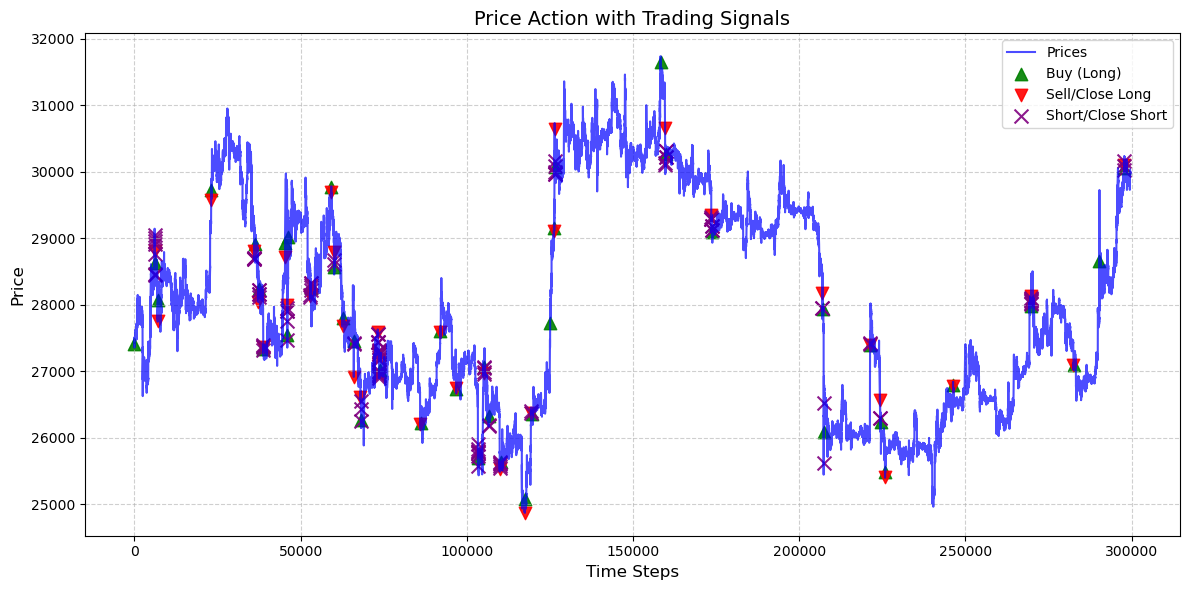

In [30]:
# Plot prices and actions
plt.figure(figsize=(12, 6))
plt.plot(trading_data['prices'], label='Prices', color='blue', alpha=0.7, linewidth=1.5)

# Highlight trade actions
buy_indices = trading_data[trading_data['Action'] == 'Buy'].index
sell_long_indices = trading_data[trading_data['Action'].isin(['Sell (Long)', 'StopLoss (Long)', 'TakeProfit (Long)'])].index
sell_short_indices = trading_data[trading_data['Action'].isin(['Sell (Short)', 'StopLoss (Short)', 'TakeProfit (Short)'])].index

plt.scatter(buy_indices, trading_data.loc[buy_indices, 'prices'],
            color='green', label='Buy (Long)', marker='^', s=80, alpha=0.9)
plt.scatter(sell_long_indices, trading_data.loc[sell_long_indices, 'prices'],
            color='red', label='Sell/Close Long', marker='v', s=80, alpha=0.9)
plt.scatter(sell_short_indices, trading_data.loc[sell_short_indices, 'prices'],
            color='purple', label='Short/Close Short', marker='x', s=100, alpha=0.9)

plt.title('Price Action with Trading Signals', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [31]:
# --- Calculate Cumulative Moving Averages ---
cumulative_average_total = pd.Series(total_capital_history).expanding(min_periods=1).mean()
cumulative_average_usd = pd.Series(usd_balance_history).expanding(min_periods=1).mean()
cumulative_average_btc = pd.Series(btc_balance_history).expanding(min_periods=1).mean()

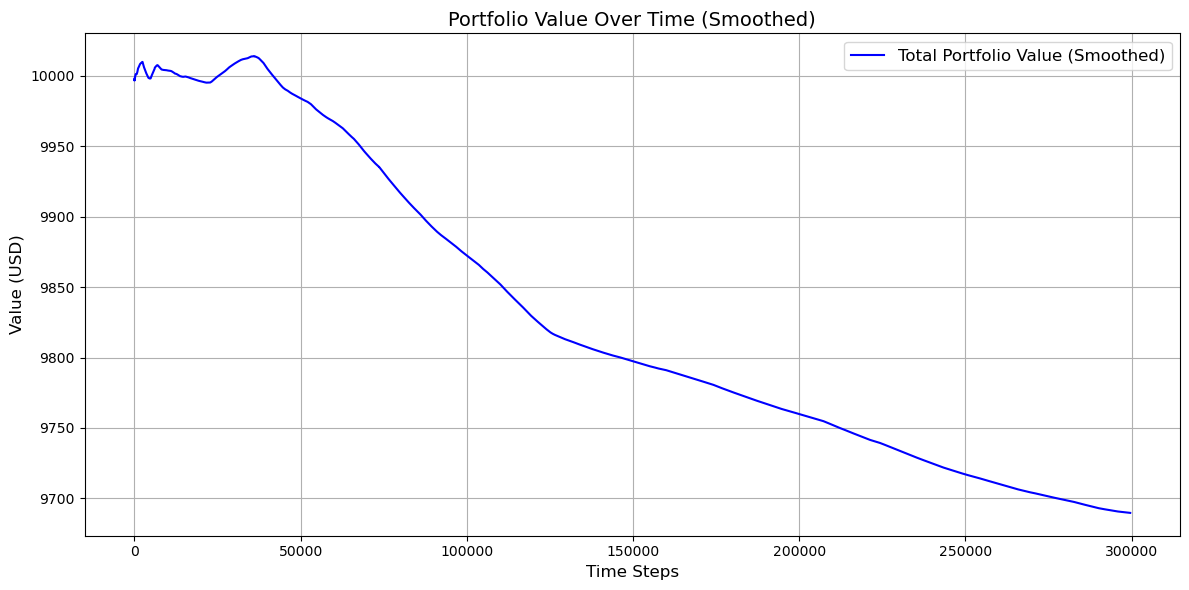

In [32]:
# --- Plot Portfolio Value Progression ---
plt.figure(figsize=(12, 6))
plt.plot(cumulative_average_total, label="Total Portfolio Value (Smoothed)", color='blue')
plt.title("Portfolio Value Over Time (Smoothed)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Value (USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

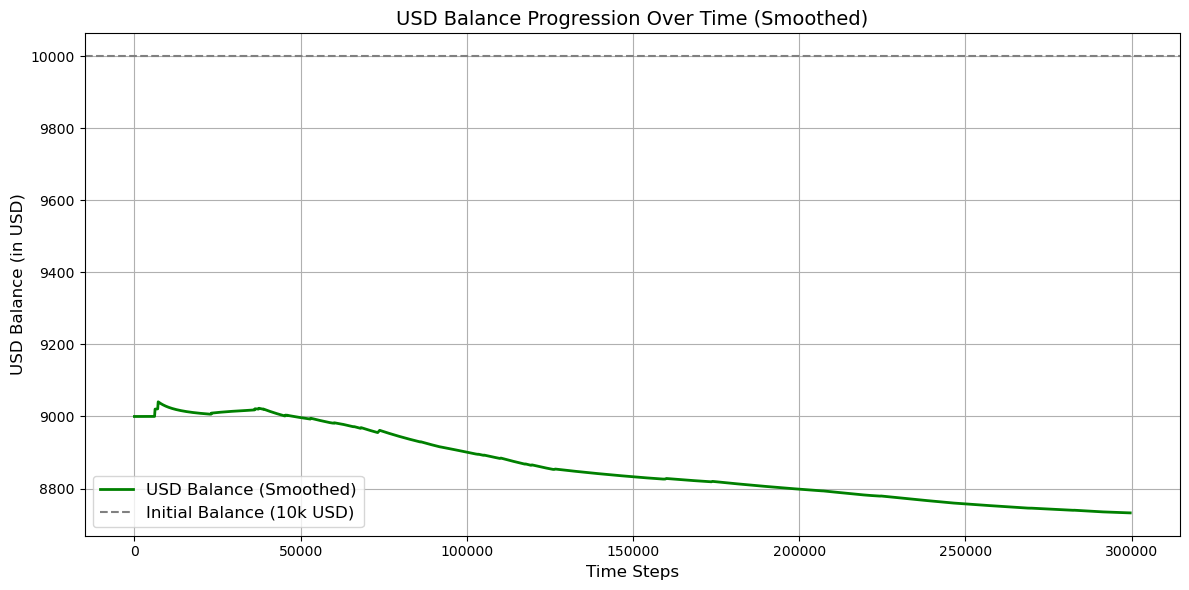

In [33]:
# --- Plot USD Balance Progression ---
plt.figure(figsize=(12, 6))
plt.plot(cumulative_average_usd, label="USD Balance (Smoothed)", color='green', linewidth=2)
plt.axhline(y=10000, color='gray', linestyle='--', label="Initial Balance (10k USD)")
plt.title("USD Balance Progression Over Time (Smoothed)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("USD Balance (in USD)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

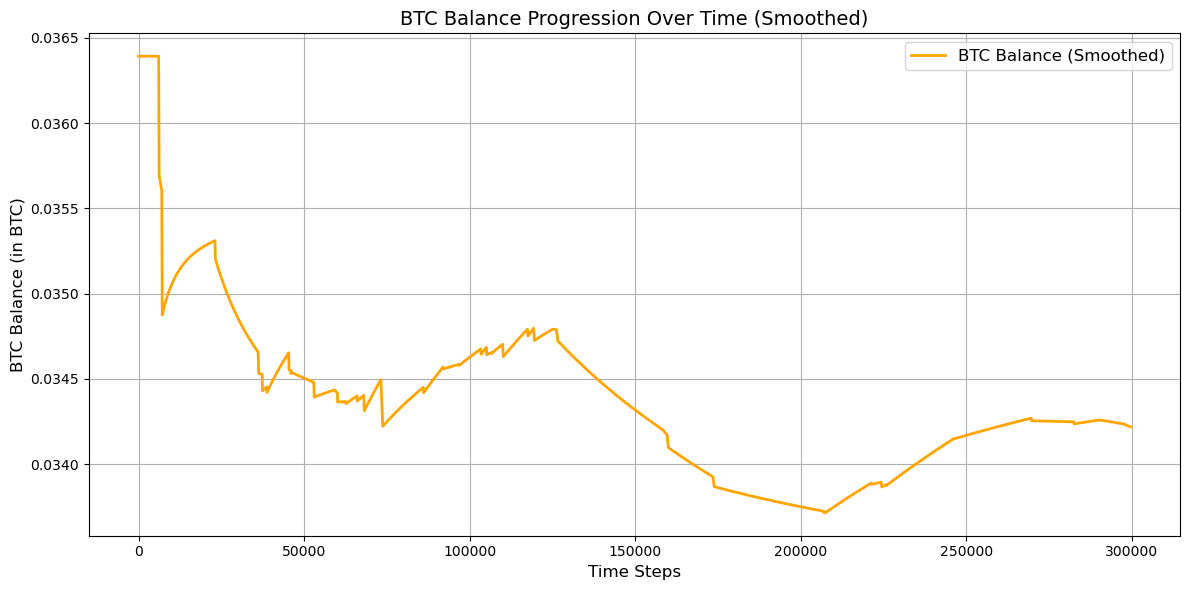

In [34]:
# --- Plot BTC Balance Progression ---
plt.figure(figsize=(12, 6))
plt.plot(cumulative_average_btc, label="BTC Balance (Smoothed)", color='orange', linewidth=2)
plt.title("BTC Balance Progression Over Time (Smoothed)", fontsize=14)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("BTC Balance (in BTC)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Free-up memory
plt.close('all')